<h1>Imports</h1>

In [1]:
import sys
sys.path.append( '../utilities' )
from data_engine import DataEngine
from backtesting import Backtesting
import pandas as pd
from IPython.display import clear_output
import ccxt
from datetime import datetime
from datetime import timedelta
from stocktrends import Renko


<h1>Init dataframe</h1>

In [6]:
# pairList = pairJson['hitbtc2018']
pair = 'ETH/USDT'
timeframe = '1h'
startDate = '2020-01-01T00:00:00'

dataEngine = DataEngine(session=ccxt.binance(), path_to_data='./database/')

df = dataEngine.get_historical_from_db(pair, timeframe, startDate)
df['date'] = df.index

print (df)

Successfully load 20095 candles for ETHUSDT
                        open     high      low    close       volume  \
timestamp                                                              
2020-01-01 00:00:00   129.16   129.19   128.68   128.87   7769.17336   
2020-01-01 01:00:00   128.87   130.65   128.78   130.64  11344.65516   
2020-01-01 02:00:00   130.63   130.98   130.35   130.85   7603.35623   
2020-01-01 03:00:00   130.85   130.89   129.94   130.20   4968.55433   
2020-01-01 04:00:00   130.21   130.74   130.15   130.20   3397.90747   
...                      ...      ...      ...      ...          ...   
2022-04-18 08:00:00  2892.13  2908.36  2889.27  2893.32  13064.37380   
2022-04-18 09:00:00  2893.32  2908.89  2888.15  2908.62  12663.62330   
2022-04-18 10:00:00  2908.62  2922.85  2905.05  2908.12  12784.22460   
2022-04-18 11:00:00  2908.12  2923.69  2908.12  2911.85   8982.15680   
2022-04-18 12:00:00  2911.86  2942.01  2911.11  2932.10  12002.83710   

                   

In [7]:
# Function to convert ohlc data into renko bricks. Pass dataframe name and brick size
def df_to_renko(data, n):
    data.reset_index(inplace=True)
    data.columns = [i.lower() for i in data.columns]
    df = Renko(data)
    df.brick_size = n
    renko_df = df.get_ohlc_data()
    return renko_df

In [9]:
# -- Intern parameter --
dfTest = df['2022-01-01':]
#ndfTest = df[:]
startingBalance = 1000
makerFee = 0.0002
takerFee = 0.0007

# -- Trade Functions --
# -- Condition to BUY market --

def buyCondition(rowRenko):
    if rowRenko['uptrend'] == True:
        return True
    else:
        return False 

def sellCondition(rowRenko):
    if rowRenko['uptrend'] == False:
        return True
    else:
        return False


# -- Value initialisation --
usd = startingBalance
wallet = startingBalance
coin = 0
previousRow = dfTest.iloc[0]
timeSince = 0

# -- Definition of dfTrades, that will be the dataset to do your trades analyses --
dfTrades = None
dfTrades = pd.DataFrame(columns=['date', 'position', 'reason',
                                 'price', 'frais', 'fiat', 'coins', 'wallet', 'timeSince'])

# -- Iteration on all your price dataset (df) --
for index, row in dfTest.iterrows():
    clear_output(wait=True)
    print(index)
    startRenko = datetime.strptime(str(index), '%Y-%m-%d %H:%M:%S') - timedelta(minutes=60000)
    dfComputeRenko = df[startRenko:index]
    dfRenko = df_to_renko(dfComputeRenko, row['close']*0.04)
    lastRowRenko = dfRenko.tail(1).squeeze()

    timeSince += 1
    # -- Buy market order --
    if buyCondition(lastRowRenko) and usd > 0:
        # -- You can define here at what price you buy --
        buyPrice = row['close']

        fee = takerFee * usd
        usd = usd - fee
        coin = usd / buyPrice
        usd = 0
        wallet = coin * row['close']

        # -- Add the trade to dfTrades to analyse it later --
        myrow = {
            'date': index,
            'position': "Buy",
            'reason': 'Buy Market Order',
            'price': buyPrice,
            'frais': fee,
            'fiat': usd,
            'coins': coin,
            'wallet': wallet,
            'timeSince': timeSince
        }
        dfTrades = dfTrades.append(myrow, ignore_index=True)
        timeSince = 0

    # -- Sell Market Order --
    elif sellCondition(lastRowRenko):
        if coin > 0:
            # -- You can define here at what price you buy --
            sellPrice = row['close']
            usd = coin * sellPrice
            fee = takerFee * usd
            usd = usd - fee
            coin = 0
            wallet = usd

            # -- Add the trade to DfTrades to analyse it later --
            myrow = {
                'date': index,
                'position': "Sell",
                'reason': 'Sell Market Order',
                'price': sellPrice,
                'frais': fee,
                'fiat': usd,
                'coins': coin,
                'wallet': wallet,
                'timeSince': timeSince
            }
            dfTrades = dfTrades.append(myrow, ignore_index=True)
            timeSince = 0
    
    previousRow = row

print("Final wallet", wallet)
print(dfTrades)


2022-04-18 12:00:00
Final wallet 847.1624915330156
                    date position             reason    price     frais  \
0    2022-01-12 11:00:00      Buy   Buy Market Order  3272.51       0.7   
1    2022-01-12 12:00:00     Sell  Sell Market Order   3316.6  0.708934   
2    2022-01-12 14:00:00      Buy   Buy Market Order  3375.84  0.708438   
3    2022-01-12 17:00:00     Sell  Sell Market Order  3381.44  0.709117   
4    2022-01-12 18:00:00      Buy   Buy Market Order  3372.25   0.70862   
..                   ...      ...                ...      ...       ...   
145  2022-04-06 14:00:00     Sell  Sell Market Order  3257.37  0.597741   
146  2022-04-06 16:00:00      Buy   Buy Market Order  3211.87  0.597323   
147  2022-04-06 17:00:00     Sell  Sell Market Order   3218.0  0.598044   
148  2022-04-06 22:00:00      Buy   Buy Market Order  3188.68  0.597625   
149  2022-04-06 23:00:00     Sell  Sell Market Order  3168.51  0.593429   

            fiat     coins       wallet timeSinc

In [10]:
BTobject = Backtesting()
newDf = BTobject.simple_spot_backtest_analys(dfTrades=dfTrades, dfTest=dfTest, pairSymbol=pair, timeframe=timeframe)

Pair Symbol : ETH/USDT | Timeframe : 1h
Period : [2022-01-01 00:00:00] -> [2022-04-18 12:00:00]
Starting balance : 999.3 $

----- General Informations -----
Final balance : 847.16 $
Performance vs US Dollar : -15.22 %
Buy and Hold Performence : -21.24 %
Performance vs Buy and Hold : 7.64 %
Best trade : +17.66 %, the 2022-04-06 14:00:00
Worst trade : -5.2 %, the 2022-01-24 10:00:00
Worst drawDown : - 30.88 %
Total fees :  89.25 $

----- Trades Informations -----
Total trades on period : 75
Number of positive trades : 31
Number of negative trades :  44
Trades win rate ratio : 41.33 %
Average trades performance : -0.11 %
Average positive trades : 1.81 %
Average negative trades : -1.46 %

----- Time Informations -----
Average time duration for a trade : 18.23 periods
Maximum time duration for a trade : 491 periods
Minimum time duration for a trade : 1 periods
Average time duration between two trades : 12.49 periods
Maximum time duration between two trades : 276 periods
Minimum time duratio

c:\Users\Eliott\Documents\CryptoTradingBot\backtest\../utilities\backtesting.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
c:\Users\Eliott\Documents\CryptoTradingBot\backtest\../utilities\backtesting.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)
c:\Users\Eliott\Documents\CryptoTradingBot\backtest\../utilities\backtesting.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dfTemp = dfTemp.append(myrow, ignore_index=True)


----- 2022 Performances: -15.22% -----


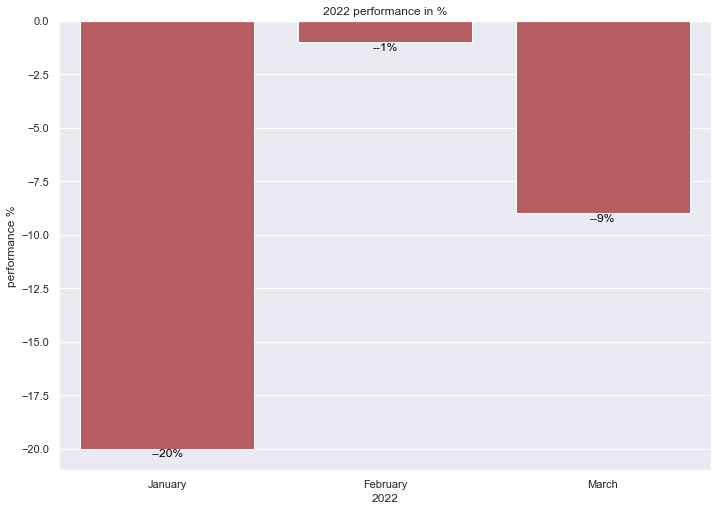

In [11]:
BTobject.plot_bar_by_month(dfTrades=dfTrades)


----- Plot -----


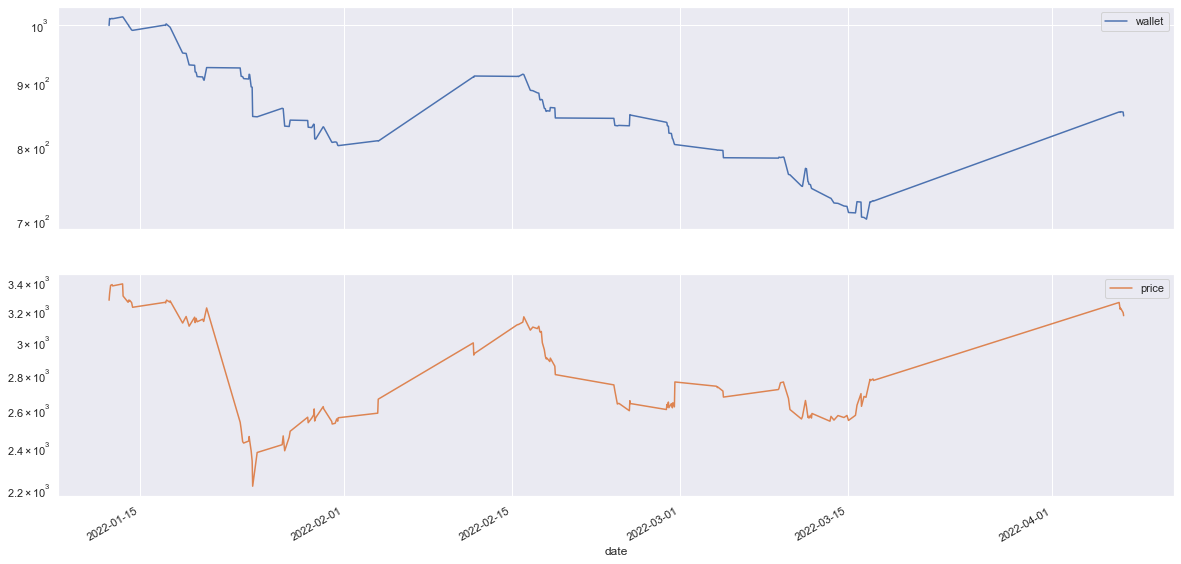

In [12]:
BTobject.plot_wallet_vs_price(dfTrades=dfTrades)